

## **Predictive Credit Risk Model**
__author__ : Jebin Jervis 

This notebook demonstrates a **Machine Learning approach** to predict credit risk using the UCI Default of Credit Card Clients dataset. It includes data preprocessing, model training, and evaluation using a Random Forest Classifier.

---

### **1. Dataset Overview**

The dataset includes the following key features:
- **ID**: Unique client ID
- **LIMIT_BAL**: Credit limit
- **AGE**: Client's age
- **SEX, EDUCATION, MARRIAGE**: Categorical demographic variables
- **PAY_0 to PAY_6**: Payment status in previous months
- **BILL_AMT1 to BILL_AMT6**: Bill statements for the past 6 months
- **PAY_AMT1 to PAY_AMT6**: Amount paid in previous months
- **default**: Target variable (1 = Default, 0 = No Default)

---

### **2. Data Preprocessing**

Key preprocessing steps include:
1. **Handling Missing Values**: Replacing NaN with column means.
2. **Standardizing Numeric Columns**: Scaling features like `LIMIT_BAL`, `AGE`, and `BILL_AMT` columns using `StandardScaler`.
3. **Encoding Categorical Variables**: Label Encoding applied to `SEX`, `EDUCATION`, `MARRIAGE`, and payment status columns (`PAY_0` to `PAY_6`).

---

### **3. Class Imbalance Check**

- The dataset has an **equal number of "Default" and "No Default" cases**.
- This confirms **no significant class imbalance**, so no resampling techniques like SMOTE are applied.

---

### **4. Model Training**

- **Model**: Random Forest Classifier
- **Hyperparameter Tuning**: GridSearchCV is used for:
  - `n_estimators`: Number of trees in the forest
  - `max_depth`: Maximum tree depth
  - `min_samples_split`: Minimum samples to split an internal node
  - `max_features`: Number of features to consider at each split

---





Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.8544832013695699
ROC AUC Score: 0.9244718659844523

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      4673
           1       0.86      0.85      0.85      4673

    accuracy                           0.85      9346
   macro avg       0.85      0.85      0.85      9346
weighted avg       0.85      0.85      0.85      9346



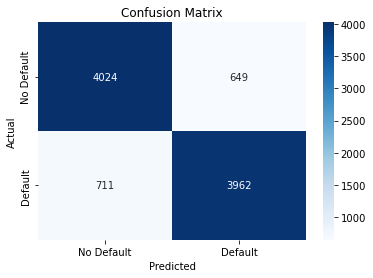

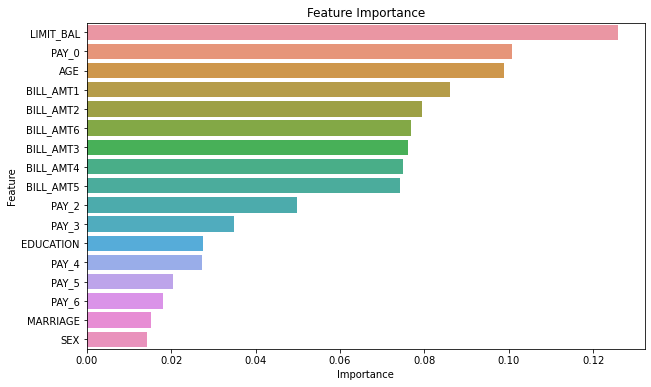

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE  # Handling class imbalance

# Load the dataset (UCI Credit Risk Dataset)
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
data = pd.read_excel(data_url, header=1)

# Drop irrelevant rows if any and reset the index
data = data[1:]
data.reset_index(drop=True, inplace=True)

# Rename columns for consistency
data.columns = [
    'ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 
    'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'
]

# Select relevant columns for modeling
selected_columns = [
    'LIMIT_BAL', 'AGE', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 
    'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'default'
]
data = data[selected_columns]

# Fill missing values with mean
data = data.fillna(data.mean())

# Standardize numeric columns
numeric_columns = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Encode categorical variables
categorical_columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

# Split the dataset into features and target
X = data.drop('default', axis=1)
y = data['default']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Train a Random Forest Classifier with GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()



### **5. Model Performance**

The following evaluation metrics are used:

#### **Classification Report**:
| Metric           | Class 0 (No Default) | Class 1 (Default) |
|------------------|----------------------|-------------------|
| **Precision**    | 0.85                 | 0.86              |
| **Recall**       | 0.86                 | 0.85              |
| **F1-Score**     | 0.86                 | 0.85              |
| **Support**      | 4673                 | 4673              |

#### **Key Metrics**:
- **Accuracy**: 85.4%
- **ROC AUC Score**: 0.924

---

### **6. Confusion Matrix**

The Confusion Matrix visualizes the model's predictions:


| **Actual vs Predicted** | **No Default (0)** | **Default (1)** |
|-------------------------|--------------------|-----------------|
| **No Default (0)**      | 4024               | 649             |
| **Default (1)**         | 711                | 3962            |

---

### **7. Feature Importance**

The top features contributing to the prediction include:
1. **LIMIT_BAL** (Credit Limit)
2. **PAY_0** (Payment status in the most recent month)
3. **AGE**
4. **BILL_AMT1** to **BILL_AMT3** (Bill statements)


---

### **8. Conclusions**

- The **Random Forest Classifier** performed well with an **Accuracy of 85.4%** and an **AUC of 0.924**.
- **LIMIT_BAL**, **PAY_0**, and **BILL_AMT** are the most important predictors of credit default.
- The dataset is balanced, simplifying the model's performance without additional resampling techniques.